In [129]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report,confusion_matrix
from tqdm import tqdm
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import treebank
from nltk.tree import Tree
import random
import optuna
from optuna.trial import TrialState

In [130]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

### StackedTransformerEncoder

#### Seed Setting

```markdown
In here, the code sets the random seed for reproducibility across random, NumPy, and PyTorch operations. This ensures consistent results by fixing the seed for both CPU and GPU computations.
```

In [131]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
set_seed()

#### Data Loading

```markdown
In here, the code loads the parsed sentences from the Penn Treebank corpus, converting them into a list of tree structures for further processing.
```

In [ ]:
trees = list(treebank.parsed_sents())

#### Frequency Counting

```markdown
In here, the code iterates through each tree to count the frequency of words and POS tags. It stores these counts in dictionaries to facilitate vocabulary construction.
```

In [132]:
word_freq = defaultdict(int)
pos_freq = defaultdict(int)

In [ ]:
for tree in trees:
    for subtree in tree.subtrees():
        if subtree.height() == 2:
            word = subtree.leaves()[0].lower()
            pos = subtree.label()
            word_freq[word] += 1
            pos_freq[pos] += 1

#### Vocabulary Building

```markdown
In here, the code constructs mappings from words and POS tags to unique indices, including special tokens for padding and unknown words. It also creates reverse mappings for later use in decoding predictions.
```

In [ ]:
min_freq = 2

word2idx = {'<PAD>': 0, '<UNK>': 1}
for word, freq in word_freq.items():
    if freq >= min_freq:
        word2idx[word] = len(word2idx)
        
pos2idx = {'<PAD>': 0}
for pos, freq in pos_freq.items():
    pos2idx[pos] = len(pos2idx)

In [ ]:
idx2word = {idx: word for word, idx in word2idx.items()}
idx2pos = {idx: pos for pos, idx in pos2idx.items()}

#### Embedding Loading

```markdown
In here, the code defines a function to load pre-trained GloVe embeddings. It initializes an embedding matrix with random values and replaces them with GloVe vectors for words present in the vocabulary.
```

In [93]:
def load_glove_embeddings(glove_file_path, embedding_dim, word2idx):
    embeddings = np.random.uniform(-0.25, 0.25, (len(word2idx), embedding_dim))
    embeddings[word2idx['<PAD>']] = np.zeros(embedding_dim)
    
    if not os.path.isfile(glove_file_path):
        raise FileNotFoundError(f"GloVe file not found at path: {glove_file_path}")
    
    with open(glove_file_path, 'r', encoding='utf8') as f:
        for line_num, line in enumerate(f):
            values = line.strip().split()
            if not values:
                continue
            word = values[0]
            vector = np.array(values[1:], dtype='float32')
            if word in word2idx:
                embeddings[word2idx[word]] = vector
            if (line_num + 1) % 100000 == 0:
                pass
    return torch.tensor(embeddings, dtype=torch.float32)

In [ ]:
embed_size = 200
embedding_matrix = load_glove_embeddings(os.path.join('data/glove.6B.200d/glove.6B.200d.txt'), embed_size, word2idx)

#### Dataset and DataLoader

```markdown
In here, the code defines a custom dataset class for the Treebank data and a collate function to handle batching and padding. It splits the data into training and validation sets and creates corresponding DataLoader instances.
```

In [94]:
class TreebankDataset(Dataset):
    def __init__(self, trees, word2idx, pos2idx):
        self.trees = trees
        self.word2idx = word2idx
        self.pos2idx = pos2idx

    def __len__(self):
        return len(self.trees)

    def __getitem__(self, idx):
        tree = self.trees[idx]
        words = [word.lower() for word in tree.leaves()]
        pos_tags = [subtree.label() for subtree in tree.subtrees() if subtree.height() == 2]
        word_indices = [self.word2idx.get(word, self.word2idx['<UNK>']) for word in words]
        pos_indices = [self.pos2idx.get(tag, self.pos2idx['<PAD>']) for tag in pos_tags]
        return torch.tensor(word_indices, dtype=torch.long), torch.tensor(pos_indices, dtype=torch.long)

def collate_fn(batch):
    batch.sort(key=lambda x: len(x[0]), reverse=True)
    sentences, pos_tags = zip(*batch)
    lengths = torch.tensor([len(s) for s in sentences], dtype=torch.long)
    padded_sentences = nn.utils.rnn.pad_sequence(sentences, batch_first=True, padding_value=word2idx['<PAD>'])
    padded_pos_tags = nn.utils.rnn.pad_sequence(pos_tags, batch_first=True, padding_value=pos2idx['<PAD>'])
    return padded_sentences, padded_pos_tags, lengths

In [ ]:
train_trees, val_trees = train_test_split(trees, test_size=0.1, random_state=42)
train_dataset = TreebankDataset(train_trees, word2idx, pos2idx)
val_dataset = TreebankDataset(val_trees, word2idx, pos2idx)

In [ ]:
batch_size = 32
train_iter = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True, 
    collate_fn=collate_fn, 
    num_workers=0
)
val_iter = DataLoader(
    val_dataset, 
    batch_size=batch_size, 
    shuffle=False, 
    collate_fn=collate_fn, 
    num_workers=0
)

#### Encoding Definition

```markdown
In here, the code defines a positional encoding module that adds positional information to word embeddings. This helps the model understand the order of words in a sequence.
```

In [95]:
class SPositionalEncoding(nn.Module):
    def __init__(self, embed_size, max_len=5000):
        super(SPositionalEncoding, self).__init__()
        
        pe = torch.zeros(max_len, embed_size)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_size, 2).float() * (-np.log(10000.0) / embed_size))
        pe[:, 0::2] = torch.sin(position * div_term)
        if embed_size % 2 == 1:
            pe[:, 1::2] = torch.cos(position * div_term[:-1])
        else:
            pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return x

#### Model Definition

```markdown
In here, the code defines a transformer-based model for POS tagging. The model includes embedding layers, positional encoding, transformer encoder layers, dropout, and a fully connected layer for outputting POS tag probabilities.
```

In [ ]:
class STransformerE(nn.Module):
    def __init__(self, vocab_size, embed_size, num_heads, hidden_dim, num_layers, output_dim, padding_idx, embedding_matrix, dropout=0.1):
        super(STransformerE, self).__init__()
        # Embedding Layer
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=padding_idx)
        self.embedding.weight = nn.Parameter(embedding_matrix)
        self.embedding.weight.requires_grad = True
        # Positional Encoding Layer
        self.pos_encoder = SPositionalEncoding(embed_size)
        # Transformer Encoder Layer
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_size, 
            nhead=num_heads, 
            dim_feedforward=hidden_dim, 
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers, norm=nn.LayerNorm(embed_size))
        # Dropout Layer
        self.dropout = nn.Dropout(dropout)
        # Fully Connected Layer
        self.fc = nn.Linear(embed_size, output_dim)
        
    def forward(self, x):
        embedded = self.embedding(x)
        embedded = self.pos_encoder(embedded)
        embedded = self.dropout(embedded)
        src_key_padding_mask = (x == self.embedding.padding_idx)
        transformer_output = self.transformer_encoder(
            embedded, 
            src_key_padding_mask=src_key_padding_mask
        )
        transformer_output = self.dropout(transformer_output)
        logits = self.fc(transformer_output)
        return logits

In [96]:
vocab_size = len(word2idx)
output_dim = len(pos2idx)
padding_idx = word2idx['<PAD>']

loss = nn.CrossEntropyLoss(ignore_index=pos2idx['<PAD>'])

#### Training Function

```markdown
In here, the code defines a function to train the model for one epoch. It iterates over the training data, computes predictions, calculates loss, performs backpropagation, and updates the model parameters. It also tracks accuracy.
```

In [97]:
def train_epoch(net, iter, trainer, loss, device):
    net.train()
    epoch_loss = 0
    correct = 0
    total = 0
    for sentences, pos_tags, lengths in tqdm(iter, desc="Training", leave=False):
        sentences = sentences.to(device)
        pos_tags = pos_tags.to(device)
        lengths = lengths.to(device)
        
        trainer.zero_grad()
        predictions = net(sentences)
        
        predictions = predictions.view(-1, predictions.shape[-1])
        pos_tags = pos_tags.view(-1)
        
        loss_v = loss(predictions, pos_tags)
        loss_v.backward()
        trainer.step()
        
        epoch_loss += loss_v.item()
        
        preds = torch.argmax(predictions, dim=1)
        mask = pos_tags != pos2idx['<PAD>']
        correct += (preds[mask] == pos_tags[mask]).sum().item()
        total += mask.sum().item()
        
    accuracy = correct / total if total > 0 else 0
    return epoch_loss / len(iter), accuracy

#### Evaluation Function

```markdown
In here, the code defines a function to evaluate the model on the validation set. It computes loss and accuracy without updating the model parameters.
```

In [ ]:
def evaluate_epoch(net, iter, loss, device):
    net.eval()
    epoch_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for sentences, pos_tags, lengths in tqdm(iter, desc="Evaluating", leave=False):
            sentences = sentences.to(device)
            pos_tags = pos_tags.to(device)
            lengths = lengths.to(device)
            
            predictions = net(sentences)
            predictions = predictions.view(-1, predictions.shape[-1])
            pos_tags = pos_tags.view(-1)
            
            loss_v = loss(predictions, pos_tags)
            epoch_loss += loss_v.item()
            
            preds = torch.argmax(predictions, dim=1)
            mask = pos_tags != pos2idx['<PAD>']
            correct += (preds[mask] == pos_tags[mask]).sum().item()
            total += mask.sum().item()
            
    accuracy = correct / total if total > 0 else 0
    return epoch_loss / len(iter), accuracy

#### Hyperparameter Tuning

```markdown
In here, the code utilizes Optuna to perform hyperparameter tuning. It defines an objective function that trains the model with different hyperparameters and returns the best validation accuracy. The study is then optimized over a specified number of trials.
```

In [98]:
def objective(trial):
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
    num_heads = trial.suggest_categorical('num_heads', [4, 5, 8, 10])
    hidden_dim = trial.suggest_int('hidden_dim', 256, 1024)
    num_layers = trial.suggest_int('num_layers', 2, 6)
    dropout = trial.suggest_uniform('dropout', 0.1, 0.5)

    net = STransformerE(
        vocab_size=vocab_size,
        embed_size=embed_size,
        num_heads=num_heads,
        hidden_dim=hidden_dim,
        num_layers=num_layers,
        output_dim=output_dim,
        padding_idx=padding_idx,
        embedding_matrix=embedding_matrix,
        dropout=dropout
    )
    net = net.to(device)
    
    trainer = torch.optim.Adam(net.parameters(), lr=lr)
    
    num_epochs_tuning = 10
    best_val_loss = float('inf')
    best_val_acc = 0
    
    for epoch in range(num_epochs_tuning):
        train_loss, train_acc = train_epoch(net, train_iter, trainer, loss, device)
        val_loss, val_acc = evaluate_epoch(net, val_iter, loss, device)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_val_acc = val_acc
    return best_val_acc

In [ ]:
study = optuna.create_study(direction='maximize', study_name='POS_Tagger_Hyperparam_Tuning')
study.optimize(objective, n_trials=20)
best_trial = study.best_trial
best_params = best_trial.params

In [ ]:
print("Best Hyperparameters:")
for key, value in best_trial.params.items():
    print(f"  {key}: {value}")

#### Final Training

```markdown
In here, the code initializes the model with the best hyperparameters obtained from tuning. It then trains the model for a specified number of epochs, saving the best model based on validation loss. Training and validation metrics are recorded for visualization.
```

In [ ]:
net = STransformerE(
    vocab_size=vocab_size,
    embed_size=embed_size,
    num_heads=best_params['num_heads'],
    # num_heads=5,
    hidden_dim=best_params['hidden_dim'],
    # hidden_dim=507,
    num_layers=best_params['num_layers'],
    # num_layers=4,
    output_dim=output_dim,
    padding_idx=padding_idx,
    embedding_matrix=embedding_matrix,
    dropout=best_params['dropout']
    # dropout=0.16140237719136658
)
net = net.to(device)

In [ ]:
trainer = torch.optim.AdamW(net.parameters(), lr=best_params['lr'], weight_decay=0.01)
num_epochs = 20
best_val_loss = float('inf')
train_losses = []
train_accuracies = []
val_accuracies = []

In [ ]:
for epoch in range(num_epochs):
    print(f"\nepoch {epoch + 1}/{num_epochs}")
    train_loss, train_acc = train_epoch(net, train_iter, trainer, loss, device)
    val_loss, val_acc = evaluate_epoch(net, val_iter, loss, device)
    
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    
    print(f"train loss: {train_loss:.4f}, train acc: {train_acc:.4f}, val acc: {val_acc:.4f}")
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(net.state_dict(), 'best_model.pth')

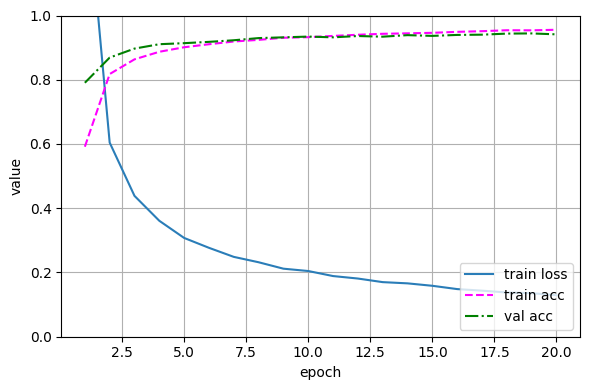

In [101]:
epochs_range = range(1, num_epochs + 1)
plt.figure(figsize=(6, 4))

plt.plot(epochs_range, train_losses, label='train loss', linestyle='-', color='#2a7db8')
plt.plot(epochs_range, train_accuracies, label='train acc', linestyle='--', color='magenta')
plt.plot(epochs_range, val_accuracies, label='val acc', linestyle='-.', color='green')
plt.xlabel('epoch')
plt.ylabel('value')
plt.ylim(0, 1)
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()

plt.show()

#### Evaluation Metrics

```markdown
In here, the code loads the best-performing model and defines a function to calculate evaluation metrics such as accuracy, precision, recall, and F1 score on the validation set.
```

In [102]:
net.load_state_dict(torch.load('best_model.pth'))

C:\Users\ASUS\AppData\Local\Temp\ipykernel_47008\2924270091.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load('best_transformer_pos_parser.p

<All keys matched successfully>

In [103]:
def cal_metrics(net, iter):
    net.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for sentences, pos_tags, lengths in tqdm(iter, desc="Predicting", leave=False):
            sentences = sentences.to(device)
            pos_tags = pos_tags.to(device)
            lengths = lengths.to(device)
            
            predictions = net(sentences)
            predicted_indices = torch.argmax(predictions, dim=-1)
            
            for i in range(sentences.size(0)):
                length = lengths[i]
                pred = predicted_indices[i][:length].cpu().numpy()
                label = pos_tags[i][:length].cpu().numpy()
                all_preds.extend(pred)
                all_labels.extend(label)
    
    pred_labels = [idx2pos[idx] for idx in all_preds if idx != pos2idx['<PAD>']]
    true_labels = [idx2pos[idx] for idx in all_labels if idx != pos2idx['<PAD>']]

    accuracy = accuracy_score(true_labels, pred_labels)
    precision = precision_score(true_labels, pred_labels, average='weighted', zero_division=0)
    recall = recall_score(true_labels, pred_labels, average='weighted', zero_division=0)
    f1 = f1_score(true_labels, pred_labels, average='weighted', zero_division=0)
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    return None

In [104]:
cal_metrics(net, val_iter)

Accuracy: 0.9436
Precision: 0.9445
Recall: 0.9436
F1 Score: 0.9436


#### Prediction

```markdown
In here, the code defines a function to predict POS tags for a given input sequence. It tokenizes the input, converts words to indices, runs the model to obtain predictions, and constructs a parse tree with predicted POS tags. Additionally, it provides descriptions for each unique POS tag in the prediction.
```

In [121]:
def predict_pos_tag(net, word2idx, idx2pos, sequence):
    net.eval()

    pos_descriptions = {
        "CC": "Coordinating Conjunction",
        "CD": "Cardinal Number",
        "DT": "Determiner",
        "EX": "Existential 'There'",
        "FW": "Foreign Word",
        "IN": "Preposition or Subordinating Conjunction",
        "JJ": "Adjective",
        "JJR": "Adjective (Comparative)",
        "JJS": "Adjective (Superlative)",
        "LS": "List Item Marker",
        "MD": "Modal",
        "NN": "Noun (Singular or Mass)",
        "NNS": "Noun (Plural)",
        "NNP": "Proper Noun (Singular)",
        "NNPS": "Proper Noun (Plural)",
        "PDT": "Predeterminer",
        "POS": "Possessive Ending",
        "PRP": "Personal Pronoun",
        "PRP$": "Possessive Pronoun",
        "RB": "Adverb",
        "RBR": "Adverb (Comparative)",
        "RBS": "Adverb (Superlative)",
        "RP": "Particle",
        "SYM": "Symbol",
        "TO": "to",
        "UH": "Interjection",
        "VB": "Verb (Base Form)",
        "VBD": "Verb (Past Tense)",
        "VBG": "Verb (Gerund or Present Participle)",
        "VBN": "Verb (Past Participle)",
        "VBP": "Verb (Non-3rd-Person Singular Present)",
        "VBZ": "Verb (3rd Person Singular Present)",
        "WDT": "Wh-Determiner",
        "WP": "Wh-Pronoun",
        "WP$": "Possessive Wh-Pronoun",
        "WRB": "Wh-Adverb"
    }

    if isinstance(sequence, str):
        words = nltk.word_tokenize(sequence)
    elif isinstance(sequence, list):
        words = sequence
    else:
        raise ValueError

    words_lower = [word.lower() for word in words]
    word_indices = [word2idx.get(word, word2idx['<UNK>']) for word in words_lower]

    input_tensor = torch.tensor([word_indices], dtype=torch.long).to(device)
    lengths = torch.tensor([len(word_indices)], dtype=torch.long).to(device)

    with torch.no_grad():
        logits = net(input_tensor)
        predictions = torch.argmax(logits, dim=-1)

    predicted_pos_indices = predictions[0][:lengths[0]].cpu().numpy()
    predicted_pos_tags = [idx2pos[idx] for idx in predicted_pos_indices]
            
    word_pos_pairs = list(zip(words, predicted_pos_tags))
    tree = Tree('S', [Tree(pos, [word]) for word, pos in word_pos_pairs])
    tree.pretty_print()

    ordered_unique_pos = []
    for pos in predicted_pos_tags:
        if pos not in ordered_unique_pos:
            ordered_unique_pos.append(pos)
        
    print("Description:")
    for pos in ordered_unique_pos:
        description = pos_descriptions.get(pos, "Unknown POS tag")
        print(f"{pos}: {description}")
        
    return tree, description

In [133]:
pos_tree = predict_pos_tag(net, word2idx, idx2pos, "The quick brown fox jumps over the lazy dog")

                      S                    
  ____________________|__________________   
 DT   JJ    NN   NN  VBD   IN   DT  JJ   JJ
 |    |     |    |    |    |    |   |    |  
The quick brown fox jumps over the lazy dog

Description:
